# Trust in the EU Parliament among citizens of EU28 
*Based on the 2019 European Election Study (EES) Voter Study data*

## Notebook 2 - Analysis



#### Introduction
In this notebook, I will utilise the data that I have previously extracted from the Stata file and answer two questions using machine learning.

1.   Can we predict whether someone trusts or distrusts the EU Parliament given their survey answers?
2.   Which characteristics can tell us whether a person is likely to trust or distrust the institution?




#### 1. Import packages

Let us start by importing all Python libraries that will be used below.

In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.inspection import plot_partial_dependence
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from defragTrees import DefragModel
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score

#### 2. Importing data 
Next, we will fetch the survey data that has been cleaned in the previous notebook. 

In [ ]:
# Import the data - the table without detailed party views.
df = pd.read_csv("cleandata_noparty.csv")
df.head()

# Store its column names before further processing.
df_col_used = df.columns

In [ ]:
# Import the data - the table including detailed party views.
df_party = pd.read_csv("cleandata_parties.csv")

# Select just the party-specific columns which are not in df - the rest of the data is identical.
# Later, we can simply add those additional features to df and focus all preprocessing efforts on df as
# they have been engineered for modelling in the previous notebook.
new_cols = list(set(df_party.columns) - set(df_col_used))
df_party = df_party[new_cols]

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


#### 3. Review of columns
Before we can perform any modelling, we should define what kinds of data we have inside the DataFrames. I will focus on what df table contains as df_party can be simply treated as additional columns (which hold numerical ratings). The approach here is to distinguish between: 

*   Features based on categorical data
*   Features based on numerical data
*   A column with individual IDs
*   A column with class labels
*   A column with longer text responses that will not be considered

This is key as each of the 4 parts of our dataset will be treated differently below.

Unfortunately, each column needed to be manually analysed. Wherever some kind of Likert scaling made sense, a characteristic would be treated as a numerical feature. Similarly, when the data was clearly numerical, it was treated as such. On the other hand, where the fields seemed to be an indication of categories, those have been grouped as categorical columns.

In this notebook, I have also ignored Q1 of the survey that contained information on what the respondents believed the most pressing issue for their countries was. While this information could be potentially useful in subsequent modelling, a topic extraction technique would need to be applied to distill what individuals thought given the length of their answers and I did not have enough time to try that. (Keep in mind that this notebook has been created to support my Data Science Nanodegree and I had deadlines to meet! :) )

In [ ]:
# Target columns = please tell me to what extent you trust the European Parliament.
# We will have 5 classes here.
## 1 = Trust a lot
## 2 = Trust 
## 3 = Nor trust neither distrust
## 4 = Distrust 
## 5 = Distrust a lot
target_column = 'Q18_2'

# Column with IDs.
id_col = "ID"

# Column with text responses.
text_col = "Q1"

# Define which columns are categorical.
cat_cols = ["Country_Original", 
            "Country_ENG", 
            "Region", 
            "Subregion",
            "Q2",
            "Q5",
            "Q6",
            "Q7",
            "Q9", 
            "Q25", 
            "D1",
            "D4a",
            "D4a_96_other",
            "D4b_1",
            "D5",
            "D6",
            "D6a",
            "D7",
            "D8",
            "D9",
            "D10",
            "D3",
            "D4_1",
            "lang_BE",
            "lang_est",
            "lang_finn",
            "lang_LT",
            "EUPresident_correct_1",
            "EUPresident_correct_2",
            "EUPresident_correct_3"]

# Define which columns are numerical.
num_cols = ["Q3",
            "Q4",
            "Q8",
            "Q11",
            "Q14_1",
            "Q14_2",
            "Q14_3",
            "Q14_4",
            "Q14_5",
            "Q14_6",
            "Q16",
            "Q18_1",
            "Q19",
            "Q20",
            "Q21",
            "Q22",
            "Q23",
            "QG32_1",
            "QG32_2",
            "QGQ34_1",
            "QG34_2",
            "QG36_1",
            "QG36_2",
            "QG38_1",
            "QG38_2",
            "QG38_3",
            "QG38_4",
            "QG38_5",
            "QG38_6",
            "D11",
            "D2_1",
            "EDU"]

# Turn all "I don't know" and similar answers into missing values.
# (In the survey, those responses have been encoded as 97, 98 or 99)
for x in df.columns:
  df.loc[df[x] == 97, [x]] = np.nan
  df.loc[df[x] == 98, [x]] = np.nan
  df.loc[df[x] == 99, [x]] = np.nan

Let us investigate how big of a problem missingness is within df now. Since we know that (intentionally!) there will be a lot of missing values in df_party, we can ignore measuring this metric for that table.

In [ ]:
# Check missingness statistics of each column (show what % is missing)
(df.isna().sum()/df.shape[0]).sort_values(ascending = False)*100

D4b_1           94.076419
D4a_96_other    93.816414
Q2              49.811591
Q25             42.245083
Q7              38.352551
                  ...    
hAge             0.000000
D4a              0.000000
D4_1             0.000000
D3               0.000000
ID               0.000000
Length: 66, dtype: float64

Apart from D4b_1 and D4a_96_other, missingness does not seem to be a major issue here! Below, I will be using XGBoost to make predictions which can handle NAs well without a need for explicit imputation or deleting observations in pre-processing steps.

In [ ]:
# Given the outputs, drop columns "D4a_96_other" and "D4b_1".
# Also, drop "Q1" column given it is full of text reponses (as explained above).
# We can also drop the "ID" column since we are not going to feed it directly into the model.
col_drop = [text_col, "D4a_96_other", "D4b_1", id_col]
df = df.drop(columns = col_drop)

We should especially check the target columns to address potential NAs there.

In [ ]:
# Analyse the how many missing values we have in the target column.
(df[target_column].isna().sum()/df.shape[0])*100

3.65513603135127

The value is pretty good! We can simply drop 4% of the rows, this operation should not have a significant impact on any results.

In [ ]:
# Remove all rows where the target column has a missing value.
df = df.dropna(subset=[target_column])

All categorical features need to be turned into dummies for our models below to "understand" them.

In [ ]:
# Apply one-hot encoding to all categorical columns in the feature matrix.
df = pd.get_dummies(df, columns = list(set(cat_cols) - set(col_drop)), dummy_na=True)

We can now separate feature columns from labels.

In [ ]:
X = df.drop(columns=[target_column])
y = df[target_column]

Lastly, let us combine df that is ready to be used in modelling with more party information from df_party.

In [ ]:
# We will combine the DataFrames as described and continue with modelling.
X_party = pd.concat([X, df_party.iloc[df.index, ]], axis=1)

This is all when it comes to preparing our data!

#### 5. Applying XGBOOST
We can now fit the models and make predictions. Hyperparameters have arbitrary values - those will be tuned next.

I will fit 4 models below to explore our research problem in a broader perspective.

*   Model A: 5-point scale outcome - multiclass classification
*   Model B: 3-point scale outcome - multiclass classification ("I don't trust" and "I don't trust at all" responses will be combined into one; "I trust" and "I trust a lot" responses will also become one category)
*   Model C: Binary classification - "I trust" and "I trust a lot" responses will be one class, the rest of the responses another class
*   Model D: Binary classification - "I don't trust" and "I don't trust at all" responses will be one class, the rest of the responses another class

To make the code more concise, I defined a function which does the modelling, produces predictions and shows performance metrics. This function will be applied to models A, B, C and D next. It is also supported by model_assessment, a function which returns classification details.

In [ ]:
def model_assessment(model, X, y):
        '''
        The function generates performance metrics (a confusion matrix and a classification report) 
        of a model passed into it. 

        Args:
            model: A fitted model element.
            X: Your testing data.
            y: Your testing labels.

        Returns:
            -
        '''
    # Get the confusion matrix.
    print("Confusion matrix:")
    disp = plot_confusion_matrix(model, X, y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()

    # Produce a classification report.
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')  
    print("Done!")

def modelling(features, outcomes, model_name, 
              params = {'max_depth': 6, 
                        'min_child_weight': 0, 
                        'gamma': 0, 
                        'learning_rate': '0.5', 
                        'colsample_bytree': '0.75', 
                        'subsample': 1, 
                        'reg_lambda': 1,
                        'n_estimators': 150}):
        '''
        The function applies XGBoost to provided training data - fits the model, saves it
        and produces performance details.

        Args:
            features: Your training data.
            outcomes: Your training labels.
            model_name: Name that will be used in saving your model.
            params: XGBoost parameters that will govern the model's behaviour.

        Returns:
            mcl: Fitted XGBoost model.
        '''
    
    # Start measuring the processing time.
    t = time.time()

    # Split the data.
    X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

    # Establish the number of classes.
    num_classes = len(np.unique(outcomes))

    # Defining the model.
    if num_classes == 2:
      obj = 'binary:logistic'
      metric = 'auc'

      xgbc = xgb.XGBClassifier(
                    objective=obj,
                    random_state=42,
                    **params)
    
    else:
      obj = 'multi:softprob'
      metric = 'mlogloss'
      
      # We need to specify the number of classes here in a multiclass setting.
      xgbc = xgb.XGBClassifier(
                    objective=obj,
                    num_class=num_classes,
                    random_state=42,
                    **params)
    
    # Fitting the model.
    print("Model's name: %s \n" %model_name)
    print("=== Step 1. Model fitting ===")
    mcl = xgbc.fit(X_train, y_train, eval_metric=metric)
    print("Done!")
    print('\n')  

    # Find predictions and probabilities associated with them.
    print("=== Step 2. Finding predictions ===")
    pred = mcl.predict(X_test)
    proba = mcl.predict_proba(X_test)
    print("Done!")
    print('\n')  

    # Save the model as a pickle.
    print("=== Step 3. Saving the model ===")
    save_as = model_name + ".pickle.dat"
    pickle.dump(mcl, open(save_as, "wb"))
    print("Done!")
    print('\n')  

    # Produce a normalised confusion matrix.
    print("=== Step 4. Assessing the model ===")
    model_assessment(mcl, X_test, y_test)

    print('\n')  
    print("The process has been completed!")

    # Stop measuring time.
    t_delta = time.time() - t
    print("Processing time: %f seconds.\n" %t_delta)

    return mcl

In [ ]:
# Create a target where the 5 point scale has been collapsed to a 3 point scale.
y_B = [1 if outcome in [1,2] else 3 if outcome in [4,5] else 2 for outcome in y]

# Create a target where the 5 point scale has been collapsed to a 2 point scale for model C.
y_C = [1 if outcome in [1,2] else 0 for outcome in y]

# Create a target where the 5 point scale has been collapsed to a 2 point scale for model D.
y_D = [1 if outcome in [4,5] else 0 for outcome in y]

Model's name: model_A 

=== Step 1. Model fitting ===
Done!


=== Step 2. Finding predictions ===
Done!


=== Step 3. Saving the model ===
Done!


=== Step 4. Assessing the model ===
Confusion matrix:


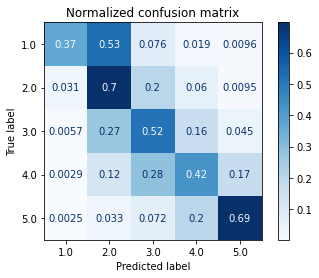

Classification Report:
              precision    recall  f1-score   support

         1.0       0.65      0.37      0.47       314
         2.0       0.61      0.70      0.65      1571
         3.0       0.51      0.52      0.51      1403
         4.0       0.47      0.42      0.45      1026
         5.0       0.69      0.69      0.69       800

    accuracy                           0.57      5114
   macro avg       0.59      0.54      0.55      5114
weighted avg       0.57      0.57      0.57      5114



Done!


The process has been completed!
Processing time: 628.507862 seconds.

Model's name: model_B 

=== Step 1. Model fitting ===
Done!


=== Step 2. Finding predictions ===
Done!


=== Step 3. Saving the model ===
Done!


=== Step 4. Assessing the model ===
Confusion matrix:


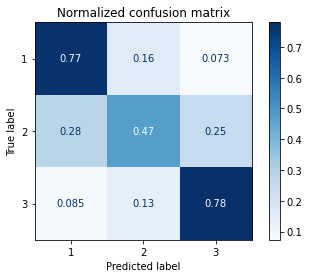

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.77      0.75      1885
           2       0.55      0.47      0.51      1403
           3       0.75      0.78      0.76      1826

    accuracy                           0.69      5114
   macro avg       0.67      0.67      0.67      5114
weighted avg       0.68      0.69      0.69      5114



Done!


The process has been completed!
Processing time: 384.960686 seconds.

Model's name: model_C 

=== Step 1. Model fitting ===
Done!


=== Step 2. Finding predictions ===
Done!


=== Step 3. Saving the model ===
Done!


=== Step 4. Assessing the model ===
Confusion matrix:


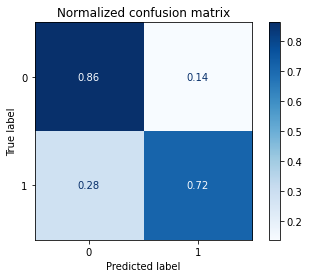

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3229
           1       0.75      0.72      0.73      1885

    accuracy                           0.81      5114
   macro avg       0.79      0.79      0.79      5114
weighted avg       0.81      0.81      0.81      5114



Done!


The process has been completed!
Processing time: 130.761163 seconds.

Model's name: model_D 

=== Step 1. Model fitting ===
Done!


=== Step 2. Finding predictions ===
Done!


=== Step 3. Saving the model ===
Done!


=== Step 4. Assessing the model ===
Confusion matrix:


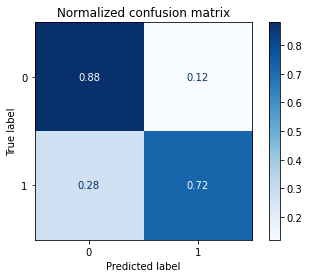

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      3288
           1       0.77      0.72      0.75      1826

    accuracy                           0.82      5114
   macro avg       0.81      0.80      0.81      5114
weighted avg       0.82      0.82      0.82      5114



Done!


The process has been completed!
Processing time: 134.301006 seconds.



In [ ]:
# Fit the models as explained above.
model_A = modelling(X_party, y, "model_A")
model_B = modelling(X_party, y_B, "model_B")
model_C = modelling(X_party, y_C, "model_C")
model_D = modelling(X_party, y_D, "model_D")

#### 6. Model optimisation
Now, let us try to tune one of the models. I will focus my efforts on model C.


In [ ]:
# Preparing the data.
X_hyper_train, X_hyper_test, y_hyper_train, y_hyper_test = train_test_split(X_party, y_C, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter optimisation.

# Define the functions for the Python library to minimise. 
def objective(params):

    # Here is the list of hyperparameters that will be considered when optimising.
    params = {
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'gamma': "{:.3f}".format(params['gamma']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'n_estimators': int(params['n_estimators']),
    }
    
    # Here is the model.
    # We will be estimating with a GPU.
    clf = xgb.XGBClassifier(
                    objective='binary:logistic',
                    tree_method="gpu_hist",
                    random_state=42,
                    **params
    )

    # Here is the scoring function - we will be ensuring that "score" variable takes as small value as possible.
    score = cross_val_score(clf, 
                            X_hyper_train, 
                            y_hyper_train, 
                            scoring="neg_log_loss", 
                            cv = StratifiedKFold(shuffle=True, random_state=42)).mean()*(-1)
    
    print("Log loss of {:.3f} for the selected parameters {}".format(score, params))
    return score

# These are the distributions from which sample values of hyperparameters will be generated for optimisations.
space = {
    'gamma':            hp.uniform('gamma', 0.0, 0.9),
    'learning_rate':    hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth', np.arange(5, 30, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.2, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(50, 500, 50, dtype=int)),
}

# Run the process.
best = fmin(fn=objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 30)

# Show the optimal values.
print("Optimal parameters: {}".format(best))

Log loss of 0.429 for the selected parameters {'max_depth': 21, 'min_child_weight': 3, 'gamma': '0.265', 'learning_rate': '0.100', 'colsample_bytree': '0.600', 'subsample': '0.837', 'n_estimators': 300}
Log loss of 0.389 for the selected parameters {'max_depth': 23, 'min_child_weight': 6, 'gamma': '0.847', 'learning_rate': '0.100', 'colsample_bytree': '0.500', 'subsample': '0.669', 'n_estimators': 50}
Log loss of 0.428 for the selected parameters {'max_depth': 16, 'min_child_weight': 5, 'gamma': '0.400', 'learning_rate': '0.150', 'colsample_bytree': '0.600', 'subsample': '0.999', 'n_estimators': 300}
Log loss of 0.405 for the selected parameters {'max_depth': 13, 'min_child_weight': 4, 'gamma': '0.413', 'learning_rate': '0.100', 'colsample_bytree': '0.600', 'subsample': '0.835', 'n_estimators': 350}
Log loss of 0.384 for the selected parameters {'max_depth': 10, 'min_child_weight': 5, 'gamma': '0.661', 'learning_rate': '0.100', 'colsample_bytree': '0.700', 'subsample': '0.838', 'n_esti

My session crashed at the 19th iteration of the code above as I have used up all the allocated RAM! 

Let us proceed then with the best parameters that the algorithm found.

Model's name: model_opt 

=== Step 1. Model fitting ===
Done!


=== Step 2. Finding predictions ===
Done!


=== Step 3. Saving the model ===
Done!


=== Step 4. Assessing the model ===
Confusion matrix:


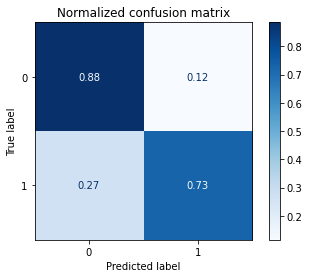

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      3229
           1       0.79      0.73      0.76      1885

    accuracy                           0.83      5114
   macro avg       0.82      0.81      0.81      5114
weighted avg       0.83      0.83      0.83      5114



Done!


The process has been completed!
Processing time: 163.703258 seconds.



In [ ]:
# Use the best parameters from above and run the model again.
best_params = {'max_depth': 10, 'min_child_weight': 5, 'gamma': '0.661', 'learning_rate': '0.100', 'colsample_bytree': '0.700', 'subsample': '0.838', 'n_estimators': 100}

mcl_hyper = modelling(X_party, y_C, "model_opt", params = best_params)

It turns out that we have managed to build quite a good promoter/doubter model (those who openly trust the EU Parliament vs those who do not)!

#### 7. Model explanation
As the last step of my analysis, I will interpret the outputs. 

In [ ]:
# TreeSHAP analysis. 

# Get SHAP values.
explainer = shap.TreeExplainer(mcl_hyper)
shap_values = explainer.shap_values(X_hyper_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


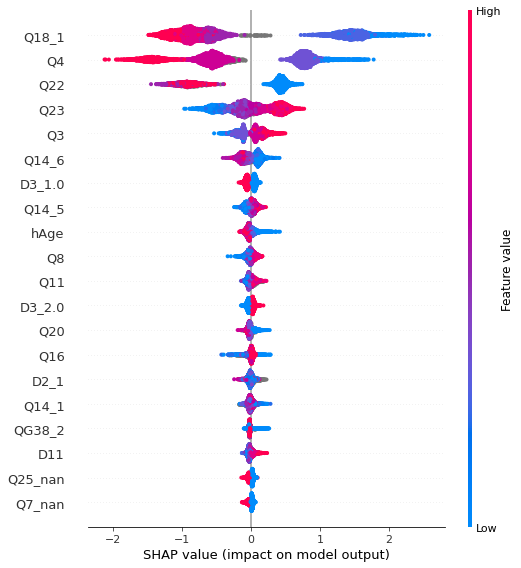

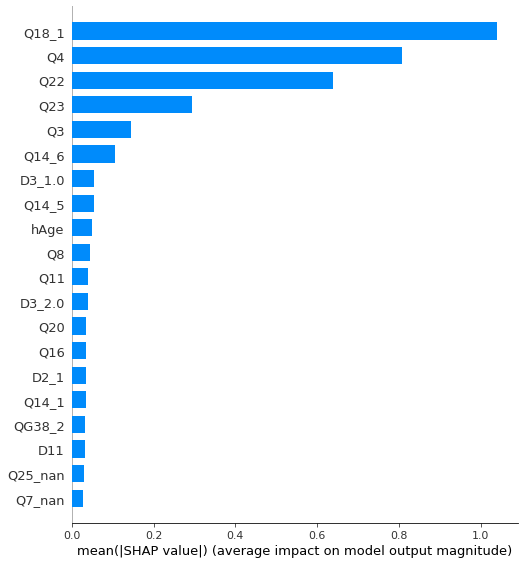

In [ ]:
# Produce summary plots.
shap.summary_plot(shap_values, X_hyper_test)
shap.summary_plot(shap_values, X_hyper_test, plot_type="bar")

We can clearly see that there are 4 features that mostly drive model predictions. These are Q18_1, Q4, Q22 and Q23.

Let us see how the model made individual-level predictions. I will randomly select 5 voters.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_hyper_test.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1000,:], X_hyper_test.iloc[1000,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2000,:], X_hyper_test.iloc[2000,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3000,:], X_hyper_test.iloc[3000,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5000,:], X_hyper_test.iloc[5000,:])

We can see the impact of questions Q18_1, Q4, Q22, Q23 as expected.

What is interesting, though, is that the national party views, even though they have some predictive power in our model as visible above, are not as important as other features. However, this could be simply due to the fact that it is a pan-European study and specific, national level information does not apply to many respondents.

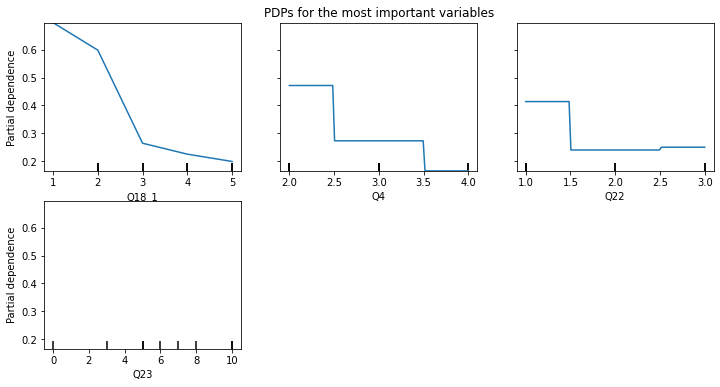

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDPs for the most important variables")
tree_disp = plot_partial_dependence(mcl_hyper, X_hyper_test, ["Q18_1", "Q4", "Q22", "Q23"], ax=ax)

Attempting to set identical bottom == top == 0.3685755431652069 results in singular transformations; automatically expanding.


<Figure size 432x288 with 0 Axes>

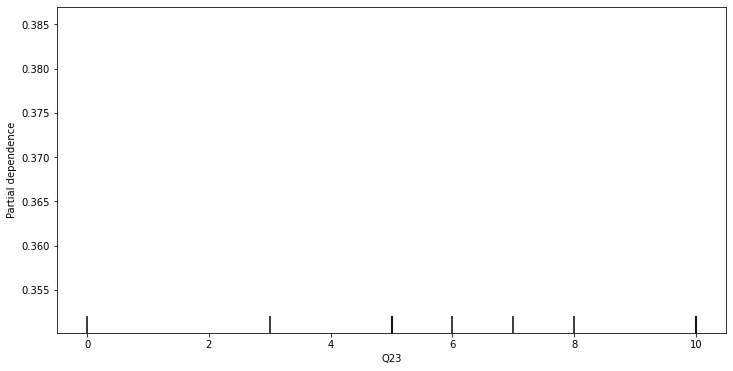

In [ ]:
# Try plotting the PDP for Q23 again.
plt.tight_layout()
fig, ax = plt.subplots(figsize=(12, 6))
Q23_PDP = plot_partial_dependence(mcl_hyper, X_hyper_test, ["Q23"], ax=ax)

We can see that in the case of variables Q18_1, Q4 and Q22, the higher the rating in each question was assigned by a respondent, the lower the probability of them openly trusting the EU Parliament. 

More intuitively, we can roughly say that:

*   **Q18_1** - the less someone trusts their national parliament, the less they are likely to trust the EU Parliament
*   **Q4** - the less someone is happy with the state of democracy in the EU, the less they are likely to trust the EU Parliament
*   **Q22** - the less someone is supportive of their country's EU membership, the less they are likely to trust the EU Parliament

One interesting thing to note is that the likelihoods for Q22 for those who do not support their national EU memberships and those who have no view about the issue are almost identical.



As for Q23, it appears that the PDP cannot be made due to singularity issues.

Let us compare the relationships we have established with what SHAP could produce for us. I will try to capture some interactions between the 4 most important variables in the plots below too.

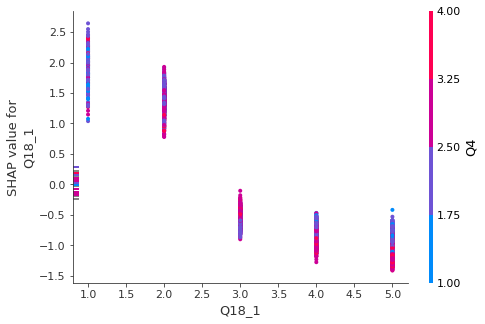

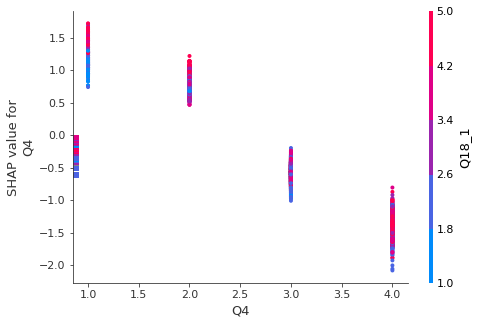

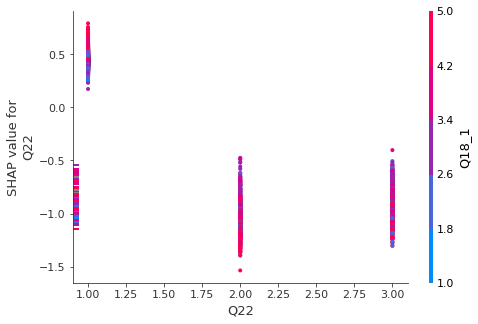

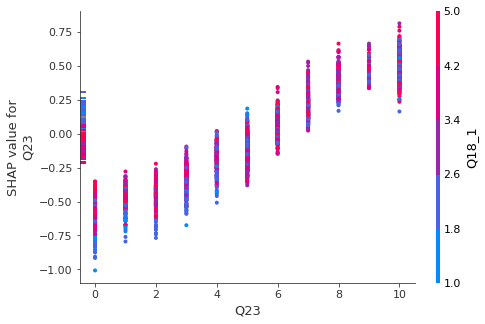

In [ ]:
# Get indices of the most important features.
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# Make SHAP dependence plots of the 4 most important features.
# Use Q4 and Q18_1 as features possibly influencing SHAP values.
for i, j in [(0,"Q4"), (1,"Q18_1"), (2,"Q18_1"), (3,"Q18_1")]:
    shap.dependence_plot(top_inds[i], shap_values, X_hyper_test, interaction_index=j)

We can also look at correlations between the 20 most important features in general, since we are discussing those here.

In [ ]:
corr = X_party[X_party.columns[top_inds[:20]].values.tolist()].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Q18_1,Q4,Q22,Q23,Q3,Q14_6,D3_1.0,Q14_5,hAge,Q8,Q11,D3_2.0,Q20,Q16,D2_1,Q14_1,QG38_2,D11,Q25_nan,Q7_nan
Q18_1,1.00,0.30,0.19,-0.14,0.55,-0.07,-0.03,-0.03,-0.06,-0.15,-0.02,0.03,0.38,-0.09,-0.02,0.09,-0.12,-0.17,0.21,0.18
Q4,0.30,1.00,0.36,-0.40,0.51,0.03,0.00,-0.15,0.11,-0.12,-0.01,-0.00,0.25,-0.11,-0.02,0.00,0.01,-0.17,0.10,0.10
Q22,0.19,0.36,1.00,-0.39,0.20,0.08,-0.06,-0.09,-0.04,-0.15,0.01,0.06,0.14,-0.24,-0.05,0.01,-0.01,-0.10,0.09,0.17
Q23,-0.14,-0.40,-0.39,1.00,-0.13,-0.09,0.02,0.21,-0.03,0.17,-0.05,-0.02,-0.13,0.17,0.06,0.01,-0.08,0.13,-0.07,-0.10
Q3,0.55,0.51,0.20,-0.13,1.00,-0.07,-0.04,-0.03,0.02,-0.10,-0.05,0.04,0.40,-0.11,-0.01,0.06,-0.12,-0.21,0.18,0.15
Q14_6,-0.07,0.03,0.08,-0.09,-0.07,1.00,0.07,0.02,0.03,0.02,0.19,-0.07,-0.02,-0.13,-0.00,0.16,0.09,0.07,-0.05,-0.03
D3_1.0,-0.03,0.00,-0.06,0.02,-0.04,0.07,1.00,-0.04,-0.02,0.07,0.04,-1.00,-0.05,-0.01,0.01,0.04,-0.00,0.05,-0.09,-0.05
Q14_5,-0.03,-0.15,-0.09,0.21,-0.03,0.02,-0.04,1.00,-0.07,0.06,-0.16,0.04,-0.01,-0.00,0.02,0.05,-0.04,0.05,-0.01,-0.01
hAge,-0.06,0.11,-0.04,-0.03,0.02,0.03,-0.02,-0.07,1.00,0.14,-0.00,0.03,0.05,0.19,0.10,-0.01,-0.02,-0.04,-0.08,-0.17
Q8,-0.15,-0.12,-0.15,0.17,-0.10,0.02,0.07,0.06,0.14,1.00,0.06,-0.07,-0.08,0.16,0.06,0.03,-0.15,0.14,-0.27,-0.36


We do not see too many strong linear correlations between our features apart from Q3 and Q4 as well as Q3 and Q18_1.

Finally, let us validate the feature importances generated by SHAP by comparing what gain values from our model tell us.

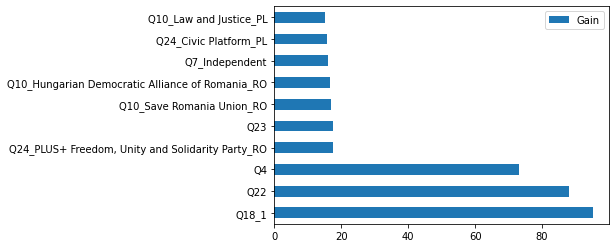

In [ ]:
# Get gain values from our XGBoost model to validate feature importances.
# Gain = relative contribution of the feature to the model.
xgboost_importances = mcl_hyper.get_booster().get_score(importance_type='gain')
importances_names = list(xgboost_importances.keys())
importances_vals = list(xgboost_importances.values())

# Plot the results for the top 10 features.
top_feats_xgb = pd.DataFrame(data=importances_vals, index=importances_names, columns=["score"]).sort_values(by = "score", ascending=False).iloc[0:10,:]
top_feats_xgb = top_feats_xgb.rename(columns={"score": "Gain"})
top_feats_xgb.plot(kind='barh');

#### 8. Model simplification
As the last step of my analysis, I will try to craft a simpler model which can deliver satisfactory performance with only a couple of features.

I will also apply a defragTrees algorithm to derive rules from this leaner XGBoost model. 

Our aim is to get something that achieves an accuracy of 80%. 

We will start by building a model that takes only one feature, assess its performance, then add another characteristic and keep repeating the process until the threshold is reached.

The most important features as per SHAP output will be plugged in first.

n=1, Accuracy: 75.85%
Variables considered:
['Q18_1']
n=2, Accuracy: 77.85%
Variables considered:
['Q18_1', 'Q4']
n=3, Accuracy: 79.94%
Variables considered:
['Q18_1', 'Q4', 'Q22']
n=4, Accuracy: 80.86%
Variables considered:
['Q18_1', 'Q4', 'Q22', 'Q23']
Threshold reached!


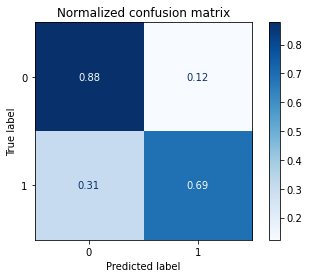

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3229
           1       0.77      0.69      0.73      1885

    accuracy                           0.81      5114
   macro avg       0.80      0.78      0.79      5114
weighted avg       0.81      0.81      0.81      5114



In [ ]:
# Perform feature selection.
features_selected = []

# Go through the list of sorted indices of columns...
# (starting from the most important features)
for col_idx in top_inds.tolist():

# Add a feature to features_selected...
  features_selected.append(col_idx)

  # Select the columns of your Dataframe based on features_selected.
  select_X_train = X_hyper_train.iloc[:, features_selected]
  select_X_test = X_hyper_test.iloc[:, features_selected]
 
  # Train the model using selected features only.
  selection_model = xgb.XGBClassifier(
                objective='binary:logistic',
                random_state=42,
                **best_params
  )
  selection_model.fit(select_X_train, y_hyper_train, eval_metric='auc')
 
  # Evaluate it.
  predictions = selection_model.predict(select_X_test)
  accuracy = accuracy_score(y_hyper_test, predictions)

  print("n=%d, Accuracy: %.2f%%" % (select_X_train.shape[1], accuracy*100.0))
  print("Variables considered:")
  print(select_X_train.columns.tolist())

  if accuracy >= 0.8: # Stop once the accuracy exceeds or is equal to 80%.

    # Get more detailed performance metrics.
    print("Threshold reached!")
    disp = plot_confusion_matrix(selection_model, select_X_test, y_hyper_test,
                              cmap=plt.cm.Blues,
                              normalize='true')

    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()
    print(classification_report(y_hyper_test, predictions))
    break

It turns out that by considering only the top 4 features, we can build a model that can perform very well! It is especially strong at predicting voters who are not EU promoters.

Could we simplify it even more? Let's try applying a rule-extraction method to our model.

In [ ]:
# Populate the missing values with column medians.
imputer = SimpleImputer(missing_values = np.nan,  
                        strategy ='median') 

filled_X = X_party[select_X_train.columns.tolist()]
imputer = imputer.fit(filled_X)     
filled_X = imputer.transform(filled_X) 

In [ ]:
# Preparing the data for modelling.
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(filled_X, y_C, test_size=0.2, random_state=40)

In [ ]:
# train xgboost
num_round = 50
dtrain = xgb.DMatrix(X_simple_train, label = y_simple_train)

param = best_params
param['objective'] = 'binary:logistic'

bst = xgb.train(param, dtrain, num_round)

# output xgb model as text
bst.dump_model('xgbmodel.txt')

# fit simplified model
Kmax = 5
splitter = DefragModel.parseXGBtrees('./xgbmodel.txt') # parse XGB model into the array of (feature index, threshold)
mdl = DefragModel(modeltype='classification', maxitr=100, qitr=0, tol=1e-6, restart=20, verbose=0)
mdl.fit(X_simple_train, np.asarray(y_simple_train), splitter, Kmax, fittype='FAB')

# results
score, cover, coll = mdl.evaluate(X_simple_test, y_simple_test)
print()
print('<< defragTrees >>')
print('----- Evaluated Results -----')
print('Test Error = %f' % (score,))
print('Test Coverage = %f' % (cover,))
print('Overlap = %f' % (coll,))
print()
print('----- Found Rules -----')
print(mdl)

[Seed   0] TrainingError = 0.26, K = 5
[Seed   1] TrainingError = 0.26, K = 5
[Seed   2] TrainingError = 0.24, K = 5
[Seed   3] TrainingError = 0.24, K = 5
[Seed   4] TrainingError = 0.28, K = 5
[Seed   5] TrainingError = 0.24, K = 5
[Seed   6] TrainingError = 0.32, K = 5
[Seed   7] TrainingError = 0.24, K = 5
[Seed   8] TrainingError = 0.29, K = 5
[Seed   9] TrainingError = 0.24, K = 5
[Seed  10] TrainingError = 0.28, K = 5
[Seed  11] TrainingError = 0.28, K = 5
[Seed  12] TrainingError = 0.26, K = 4
[Seed  13] TrainingError = 0.25, K = 5
[Seed  14] TrainingError = 0.28, K = 5
[Seed  15] TrainingError = 0.28, K = 5
[Seed  16] TrainingError = 0.32, K = 4
[Seed  17] TrainingError = 0.28, K = 5
[Seed  18] TrainingError = 0.24, K = 5
[Seed  19] TrainingError = 0.26, K = 5
Optimal Model >> Seed   7, TrainingError = 0.24, K = 5

<< defragTrees >>
----- Evaluated Results -----
Test Error = 0.234063
Test Coverage = 1.000000
Overlap = 0.421588

----- Found Rules -----
[Rule  1]
y = 0 when
	 x_

We can infer then the following two rules by combining the outputs above:

*   If a respondent assigned a value greater than 1 in Q23(10-point scale, with 0 = unification has already gone too far and 10 = should be pushed further) and smaller than 4 in Q18_1 (i.e. totally trusting, somehow trusting or neither trusting nor distrusting their national parliament), they belong to group 1.
*   Otherwise, they belong to group 0.

If those statements were applied to the entire test set, we would be right in 77% of cases.

What if we simply used the rule linked to Q18_1 and did not use any imputation?

In [ ]:
# Get the actual y values.
y_true_rule = pd.DataFrame({'val': y_C, 'idx': X_party.index.tolist()}).set_index('idx')

# Remove entries where Q_18 is missing.
X_rule = X_party["Q18_1"][X_party["Q18_1"].notna()]
y_true_rule = y_true_rule[X_party["Q18_1"].notna()]

# Use the rule.
y_projected_rule = [1 if trust_level in [1,2,3] else 0 for trust_level in X_rule]
print(classification_report(y_true_rule, y_projected_rule))

              precision    recall  f1-score   support

           0       0.79      0.56      0.65     15903
           1       0.50      0.76      0.60      9472

    accuracy                           0.63     25375
   macro avg       0.65      0.66      0.63     25375
weighted avg       0.69      0.63      0.64     25375



Using a simple rule based on the trust levels can give enable us to correctly classify 76% of EU promoters across the whole dataset. Also, when the rule predicts a non-promoter, it is correct 79% of the time.